In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

In [189]:
%matplotlib inline

In [190]:
file_path = "/content/GOOG.csv"

In [191]:
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [192]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-09,117.989998,118.199997,116.559998,117.500000,117.500000,15424300
2022-08-10,119.589996,121.779999,119.360001,120.650002,120.650002,20497000
2022-08-11,122.080002,122.339996,119.550003,119.820000,119.820000,16671600
2022-08-12,121.160004,122.650002,120.400002,122.650002,122.650002,16121100
2022-08-15,122.209999,123.260002,121.570000,122.879997,122.879997,15525000


In [193]:
df.shape

(251, 6)

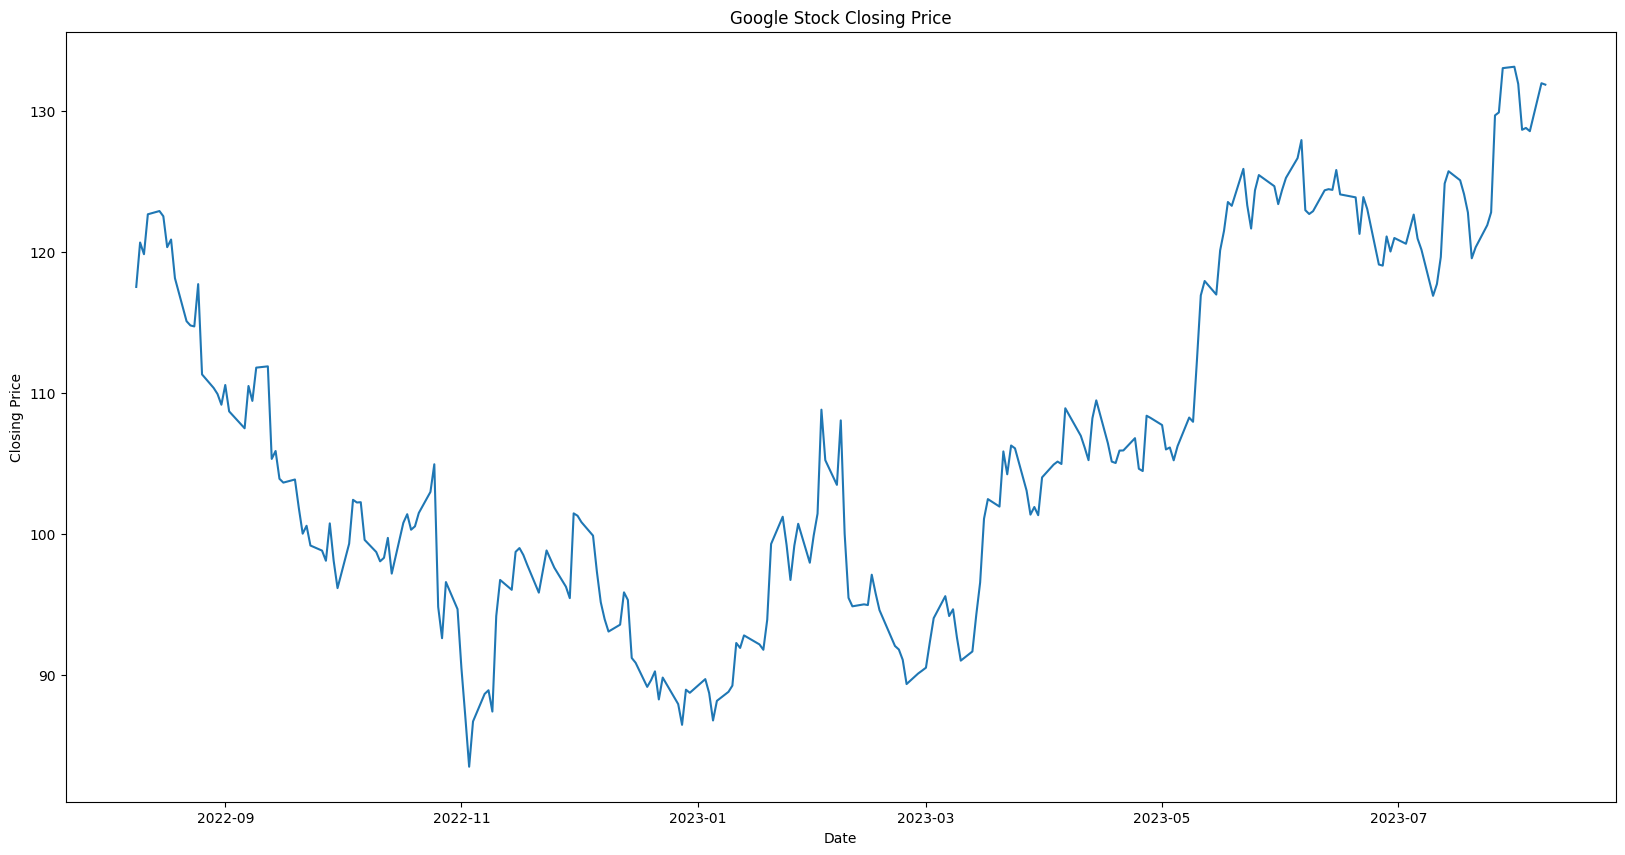

In [194]:
# Plot the closing price

plt.rc("font", size=10)

plt.figure(figsize=(20, 10))
plt.plot(df['Close'])
plt.title('Google Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

<Axes: ylabel='Density'>

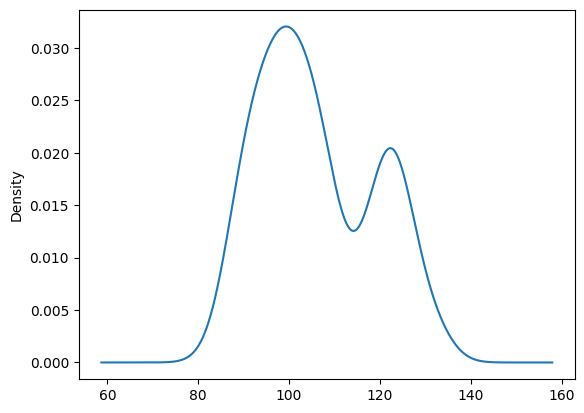

In [195]:
df_close = df['Close']
df_close.plot(kind='kde')

In [196]:
# Split the data into 3 parts
num_splits = 3
split_size = len(df) // num_splits
data_splits = [df.iloc[i * split_size: (i + 1) * split_size] for i in range(num_splits)]


In [197]:
# Calculate the mean and variance for each split
for i, data_split in enumerate(data_splits):
    mean = np.mean(data_split['Close'])
    variance = np.var(data_split['Close'])
    print(f"Split {i + 1} - Mean: {mean:.2f}, Variance: {variance:.2f}")


Split 1 - Mean: 102.91, Variance: 82.40
Split 2 - Mean: 95.75, Variance: 33.28
Split 3 - Mean: 118.68, Variance: 67.52


In [198]:
# Calculate the rolling mean and plot the graph
rolling_mean = df['Close'].rolling(window=12).mean()

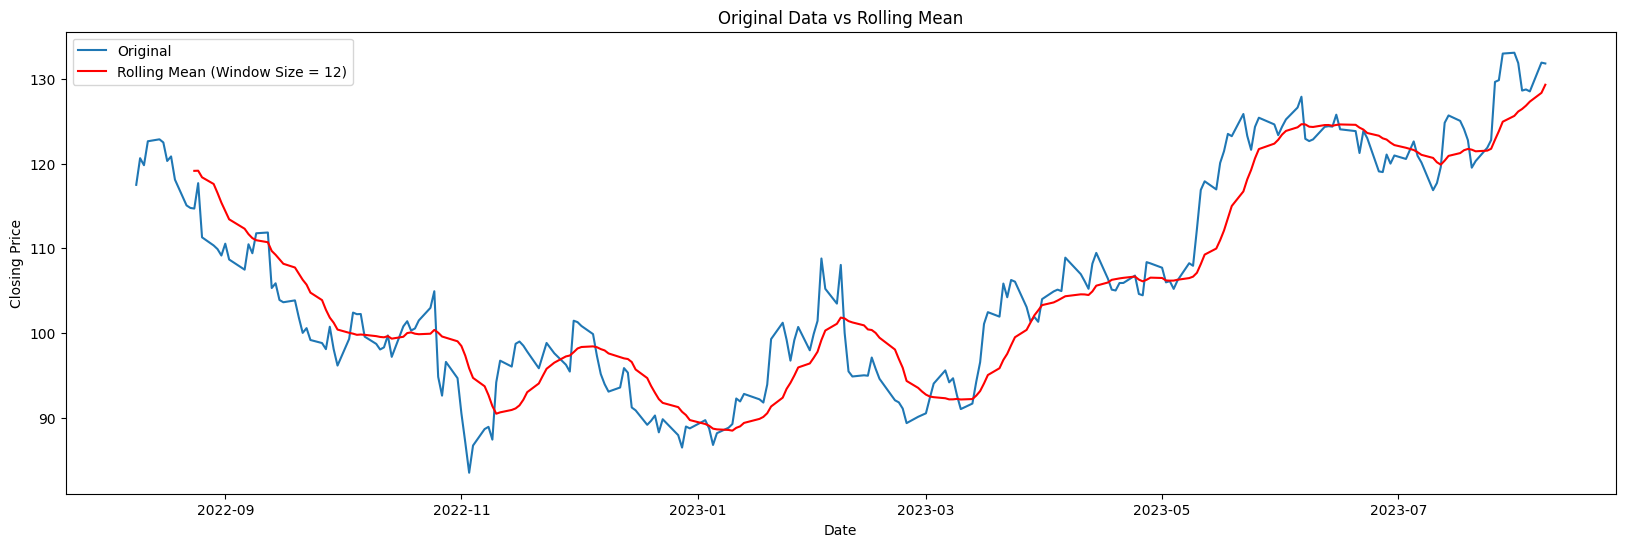

In [199]:
plt.figure(figsize=(20, 6))
plt.plot(df['Close'], label='Original')
plt.plot(rolling_mean, label='Rolling Mean (Window Size = 12)', color='red')
plt.legend()
plt.title('Original Data vs Rolling Mean')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

In [200]:
X = df["Close"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

if result[0] < result[4]["5%"]:
    print ("Reject Ho - Time Series is Stationary")
else:
    print ("Failed to Reject Ho - Time Series is Non-Stationary")

ADF Statistic: -0.893703
p-value: 0.790039
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Failed to Reject Ho - Time Series is Non-Stationary


In [201]:
# Apply differencing methods
df_diff1 = df['Close'].diff().dropna()  # First difference

df_diff2 = df['Close'].diff().diff().dropna()  # Second difference

df_log_diff = df['Close'].apply(np.log).diff().dropna()  # Log difference

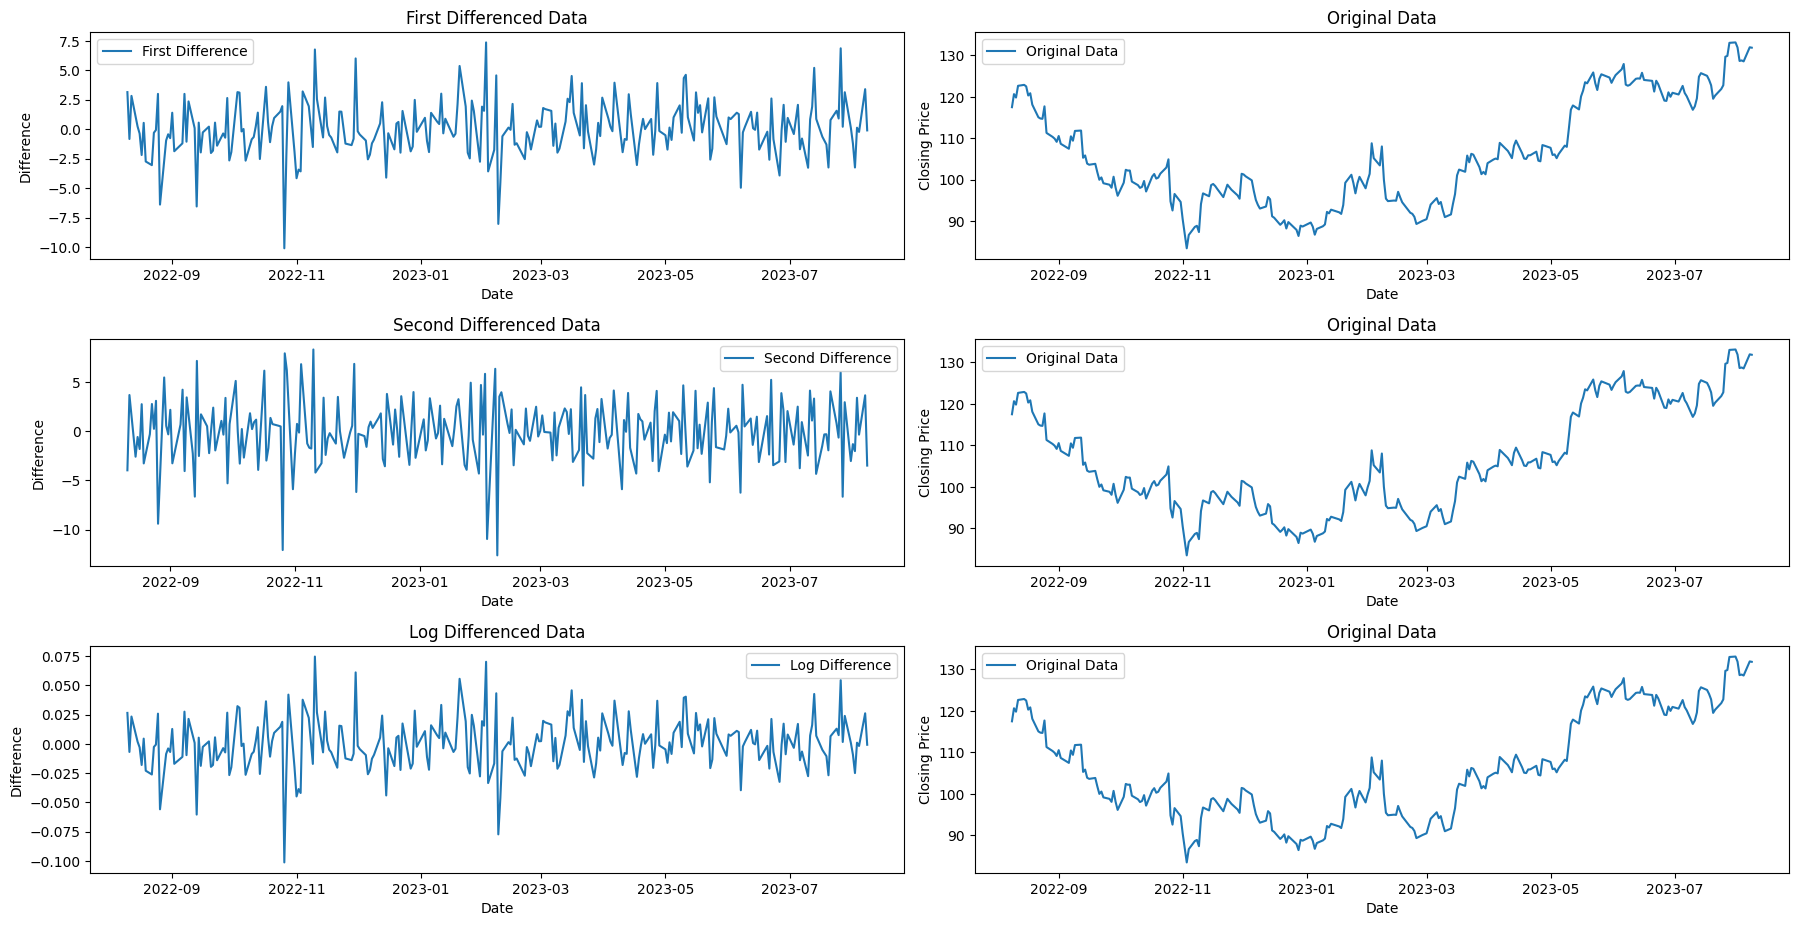

In [202]:
# Plot the differenced data
plt.figure(figsize=(18, 12))


plt.subplot(421)
plt.plot(df_diff1, label='First Difference')
plt.legend(loc='best')
plt.title('First Differenced Data')
plt.xlabel('Date')
plt.ylabel('Difference')


plt.subplot(422)
plt.plot(df['Close'], label='Original Data')
plt.legend(loc='best')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')



plt.subplot(423)
plt.plot(df_diff2, label='Second Difference')
plt.legend(loc='best')
plt.title('Second Differenced Data')
plt.xlabel('Date')
plt.ylabel('Difference')



plt.subplot(424)
plt.plot(df['Close'], label='Original Data')
plt.legend(loc='best')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')



plt.subplot(425)
plt.plot(df_log_diff, label='Log Difference')
plt.legend(loc='best')
plt.title('Log Differenced Data')
plt.xlabel('Date')
plt.ylabel('Difference')



plt.subplot(426)
plt.plot(df['Close'], label='Original Data')
plt.legend(loc='best')
plt.title('Original Data')
plt.xlabel('Date')
plt.ylabel('Closing Price')



plt.tight_layout()

In [203]:
# ADF and KPSS tests for stationarity
def test_stationarity(timeseries):
    # ADF test

    adf_test = adfuller(timeseries, autolag='AIC')
    print("ADF Test Results:")
    print(f'ADF Test Statistic: {adf_test[0]}')
    print(f'p-value: {adf_test[1]}')
    # print(f'Critical Values: {adf_test[4]}')

    # result = adfuller(timeseries, autolag='AIC')
    # print('ADF Statistic: %f' % result[0])
    # print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print(f'\t{key}: {value}')

    if adf_test[0] < adf_test[4]["5%"]:
        print ("Reject Ho - Time Series is Stationary")
    else:
        print ("Failed to Reject Ho - Time Series is Non-Stationary")


    # KPSS test
    kpss_test = kpss(timeseries, nlags='auto')
    print("\nKPSS Test Results:")
    print(f'KPSS Test Statistic: {kpss_test[0]}')
    print(f'p-value: {kpss_test[1]}')
    print(f'Critical Values: {kpss_test[3]}')

In [204]:
print("\nFirst Difference:")
test_stationarity(df_diff1)


First Difference:
ADF Test Results:
ADF Test Statistic: -11.971825846310379
p-value: 3.882320630634504e-22
Critical Values:
	1%: -3.4569962781990573
	5%: -2.8732659015936024
	10%: -2.573018897632674
Reject Ho - Time Series is Stationary

KPSS Test Results:
KPSS Test Statistic: 0.3514938486705948
p-value: 0.09806299626267465
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


In [205]:
print("\nSecond Difference:")
test_stationarity(df_diff2)


Second Difference:
ADF Test Results:
ADF Test Statistic: -8.353684562399444
p-value: 2.94802700957099e-13
Critical Values:
	1%: -3.4582467982399105
	5%: -2.8738137461081323
	10%: -2.5733111490323846
Reject Ho - Time Series is Stationary

KPSS Test Results:
KPSS Test Statistic: 0.13153242844233876
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-203-92d4b23f3d2b>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(timeseries, nlags='auto')


In [206]:
print("\nLog Difference:")
test_stationarity(df_log_diff)


Log Difference:
ADF Test Results:
ADF Test Statistic: -12.110976964109183
p-value: 1.9197212216094285e-22
Critical Values:
	1%: -3.4569962781990573
	5%: -2.8732659015936024
	10%: -2.573018897632674
Reject Ho - Time Series is Stationary

KPSS Test Results:
KPSS Test Statistic: 0.31381152797403866
p-value: 0.1
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


<ipython-input-203-92d4b23f3d2b>:25: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(timeseries, nlags='auto')


<center><h1>Auto Regressive Model</h1></center>

$$
Y_{t}=\alpha+\beta_{1} Y_{t-1}+\beta_{2} Y_{t-2}+\ldots+\beta_{p} Y_{t-p}+\epsilon_{1}
$$

In [207]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-08-09,117.989998,118.199997,116.559998,117.500000,117.500000,15424300
2022-08-10,119.589996,121.779999,119.360001,120.650002,120.650002,20497000
2022-08-11,122.080002,122.339996,119.550003,119.820000,119.820000,16671600
2022-08-12,121.160004,122.650002,120.400002,122.650002,122.650002,16121100
2022-08-15,122.209999,123.260002,121.570000,122.879997,122.879997,15525000
...,...,...,...,...,...,...
2023-08-02,129.839996,130.419998,127.849998,128.639999,128.639999,22705800
2023-08-03,128.369995,129.770004,127.775002,128.770004,128.770004,15018100
2023-08-04,129.600006,131.929993,128.315002,128.539993,128.539993,20509500


In [208]:
sdi = df.asfreq('D')
sdi = sdi[['Close']]
sdi

,Close
Date,
2022-08-09,117.500000
2022-08-10,120.650002
2022-08-11,119.820000
2022-08-12,122.650002
2022-08-13,NaN
...,...
2023-08-04,128.539993
2023-08-05,NaN
2023-08-06,NaN


In [209]:
from statsmodels.tsa.seasonal import STL

In [210]:
# in this place "use linear interpolation here" use the commands for linear interpolation.
# sdi = Seasonal Decomposition and Interpolation to interpolate missing values in the daily frequency of data

res = STL(sdi['Close'].interpolate(method="linear"), seasonal=13).fit()

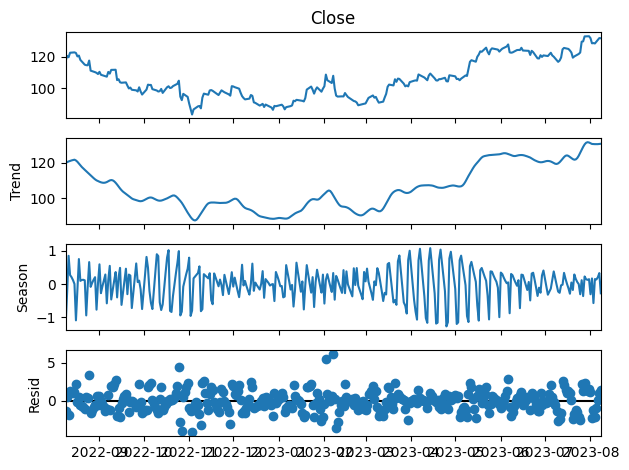

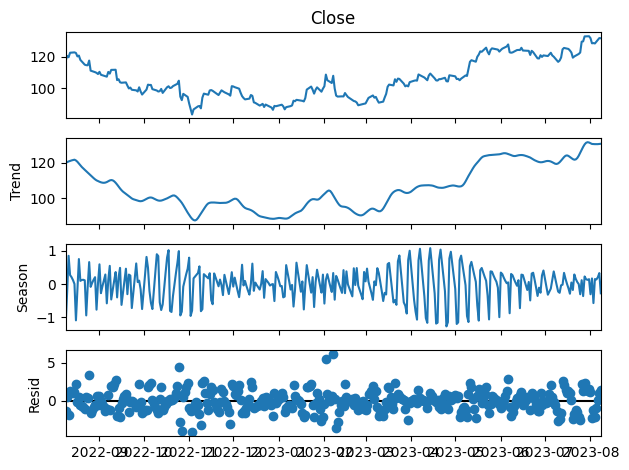

In [211]:
res.plot()

In [212]:
seasonal_component = res.seasonal
seasonal_component.head()

Date
2022-08-09   -1.224121
2022-08-10   -0.260225
2022-08-11    0.852518
2022-08-12    0.272024
2022-08-13    0.208928
Freq: D, Name: season, dtype: float64

In [213]:
sdi

,Close
Date,
2022-08-09,117.500000
2022-08-10,120.650002
2022-08-11,119.820000
2022-08-12,122.650002
2022-08-13,NaN
...,...
2023-08-04,128.539993
2023-08-05,NaN
2023-08-06,NaN


Text(0.5, 0, 'Date')

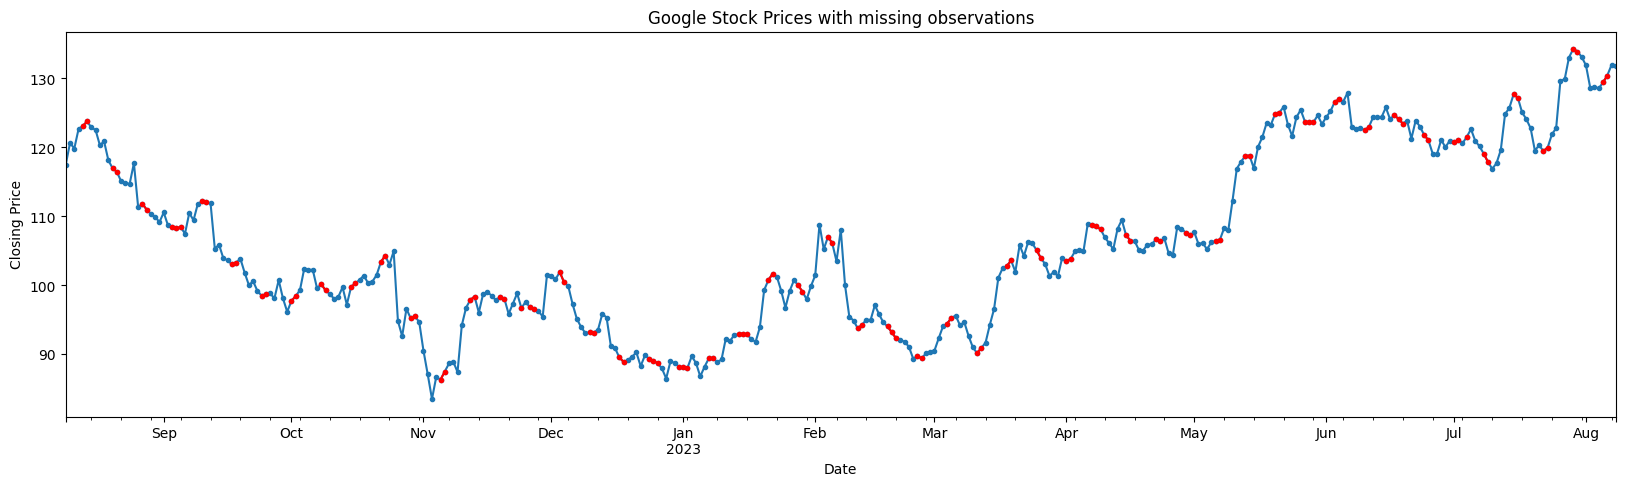

In [214]:
sdi_deseasonalised = sdi['Close'] - seasonal_component
sdi_deseasonalised_imputed = sdi_deseasonalised.interpolate(method="spline",order=3)
sdi_imputed = sdi_deseasonalised_imputed + seasonal_component

sdi_imputed = sdi_imputed.to_frame().rename(columns={0: 'Close'})

# plot
ax = sdi_imputed.plot(linestyle="-", marker=".", figsize=[20, 5], legend=None)
ax = sdi_imputed[sdi.isnull()].plot(ax=ax, legend=None, marker=".", color="r")
ax.set_title('Google Stock Prices with missing observations')
ax.set_ylabel('Closing Price')
ax.set_xlabel('Date')

In [215]:
sdi_imputed

,Close
Date,
2022-08-09,117.500000
2022-08-10,120.650002
2022-08-11,119.820000
2022-08-12,122.650002
2022-08-13,123.090103
...,...
2023-08-04,128.539993
2023-08-05,129.406770
2023-08-06,130.415954


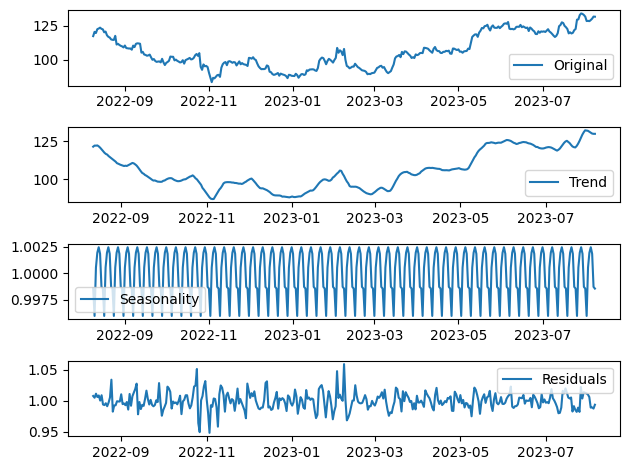

In [216]:
# perform seasonal decompose on logged transformed

decompose_result = seasonal_decompose(sdi_imputed, model='multiplicative', filt=None, period=None, two_sided=True, extrapolate_trend=0)

# perform seasonal decomposing using additive model type

trend = decompose_result.trend # get trend
seasonal = decompose_result.seasonal #get seasonal
residual = decompose_result.resid #get residual

#plot the decompose result
# decompose_result.plot("Multiplicative Decomposition")

plt.subplot(411)
plt.plot(sdi_imputed, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [217]:
# perform the ADF test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(sdi_imputed, autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.0295989868277595
2. P-Value :  0.7423162782004037
3. Num Of Lags :  4
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 360
5. Critical Values :
	 1% :  -3.448645946352023
	 5% :  -2.869602139060357
	 10% :  -2.5710650077160495


In [218]:
sdi_imputed.isnull().any()

Close    False
dtype: bool

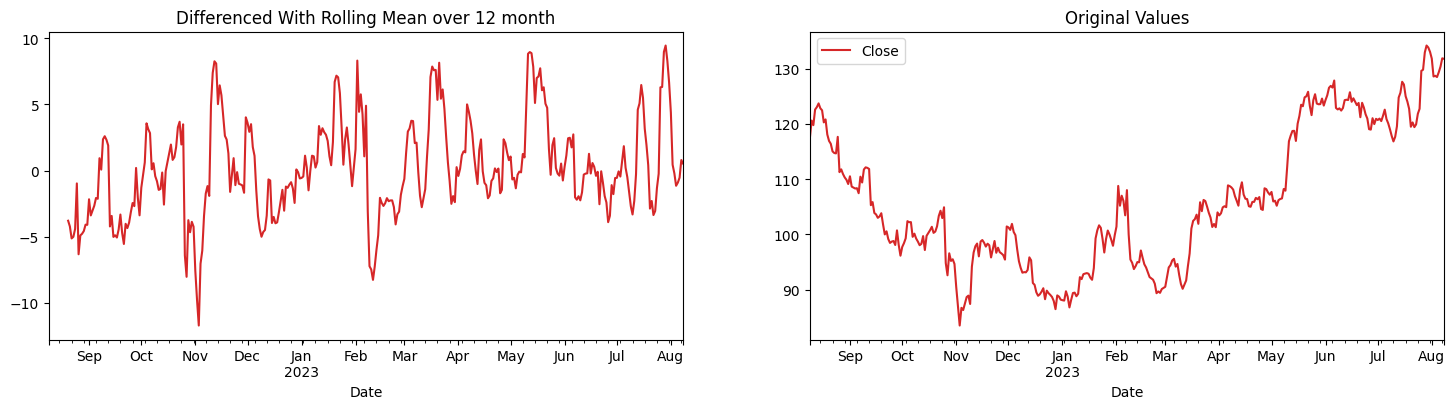

In [219]:
rolling_mean = sdi_imputed.rolling(window = 12).mean()
sdi_rolled_detrended = sdi_imputed['Close'] - rolling_mean['Close']


ax1 = plt.subplot(121)
sdi_rolled_detrended.plot(figsize=(18,4),color="tab:red", title="Differenced With Rolling Mean over 12 month", ax=ax1);
ax2 = plt.subplot(122)
sdi_imputed.plot(figsize=(18,4), color="tab:red", title="Original Values", ax=ax2);

In [220]:
sdi_rolled_detrended

Date
2022-08-09         NaN
2022-08-10         NaN
2022-08-11         NaN
2022-08-12         NaN
2022-08-13         NaN
                ...   
2023-08-04   -1.153109
2023-08-05   -0.913563
2023-08-06   -0.539876
2023-08-07    0.794173
2023-08-08    0.530000
Freq: D, Name: Close, Length: 365, dtype: float64

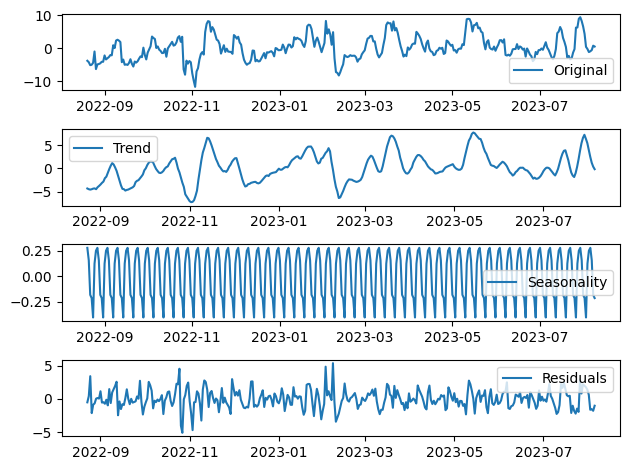

In [221]:
decompose_result = seasonal_decompose(sdi_rolled_detrended.dropna(), model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

# perform seasonal decomposing using multiplicative model type

trend = decompose_result.trend # get trend
seasonal = decompose_result.seasonal #get seasonal
residual = decompose_result.resid #get residual

#plot the decompose result
# decompose_result.plot("Multiplicative Decomposition")

plt.subplot(411)
plt.plot(sdi_rolled_detrended, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

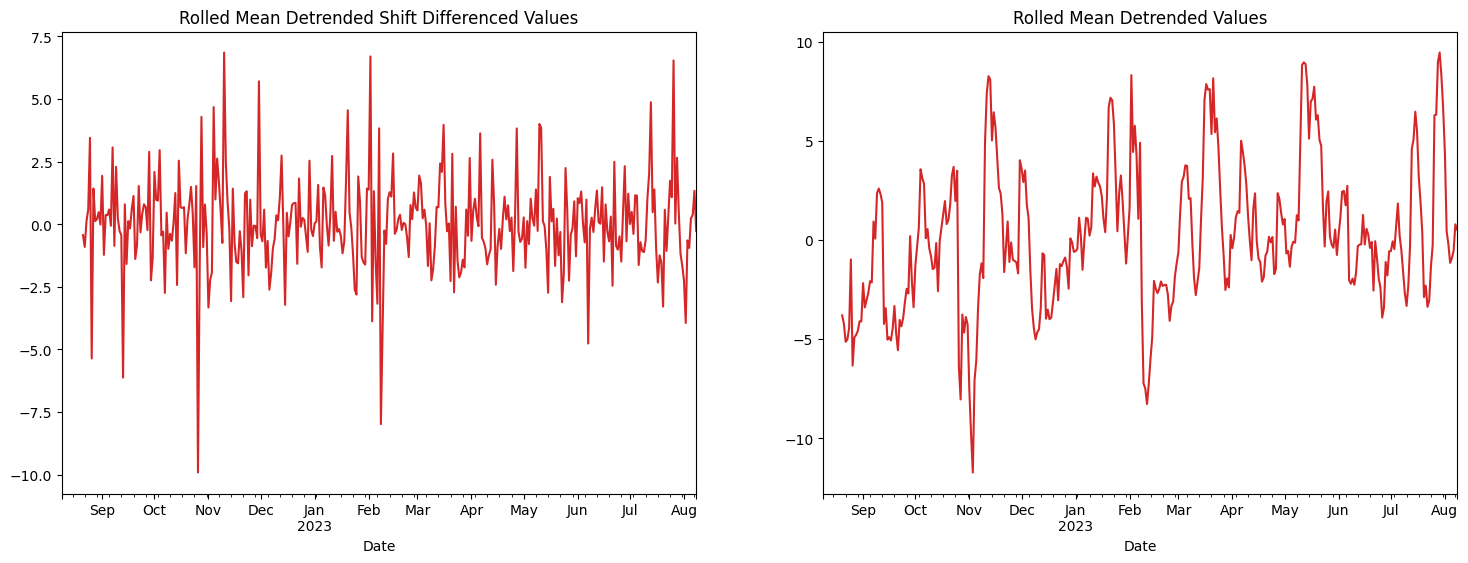

In [222]:
sdi_rolled_detrended_diff = sdi_rolled_detrended - sdi_rolled_detrended.shift()

# plot the logged_passengers_diff
ax1 = plt.subplot(121)
sdi_rolled_detrended_diff.plot(figsize=(18,6) ,color="tab:red", title="Rolled Mean Detrended Shift Differenced Values", ax=ax1);
ax2 = plt.subplot(122)
sdi_rolled_detrended.plot(color="tab:red", title="Rolled Mean Detrended Values", ax=ax2);

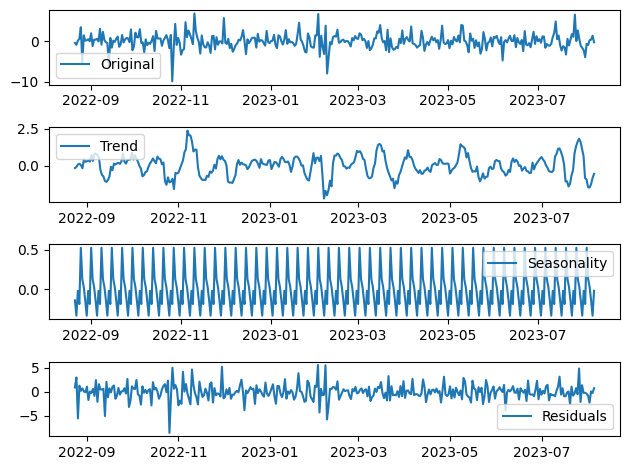

In [223]:
decompose_result = seasonal_decompose(sdi_rolled_detrended_diff.dropna(), model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)

# perform seasonal decomposing using multiplicative model type

trend = decompose_result.trend # get trend
seasonal = decompose_result.seasonal #get seasonal
residual = decompose_result.resid #get residual

#plot the decompose result
# decompose_result.plot("Multiplicative Decomposition")

plt.subplot(411)
plt.plot(sdi_rolled_detrended_diff, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

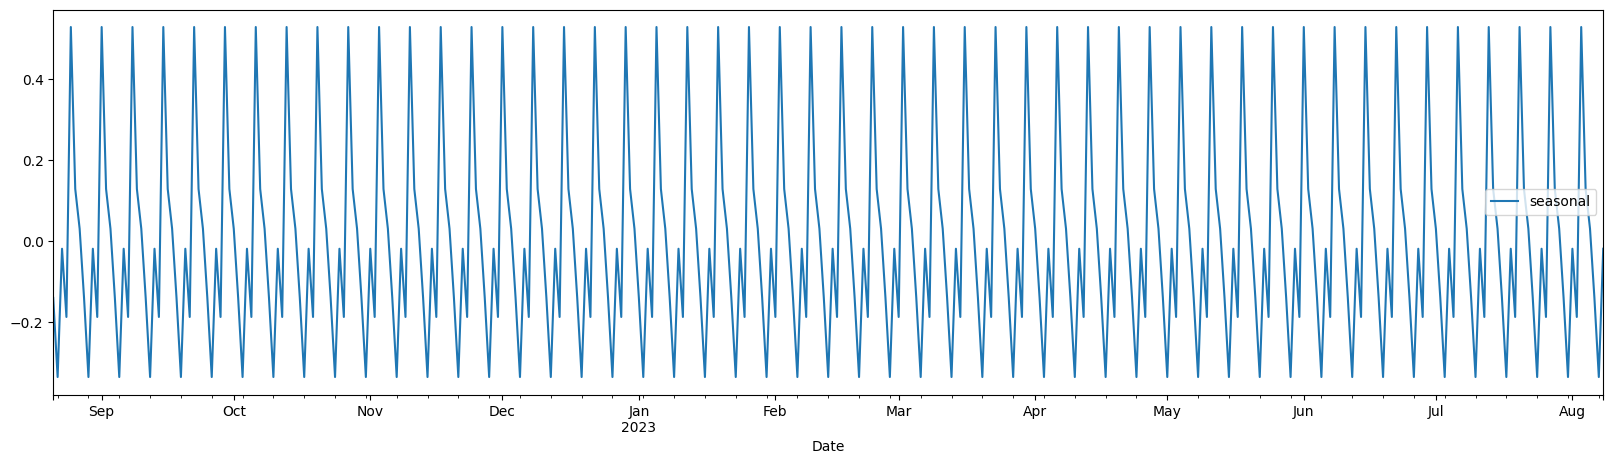

In [224]:
plt.figure(figsize=(20,5))
seasonal.plot()
plt.legend(loc='best')

In [225]:
# perform the ADF test
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(sdi_rolled_detrended_diff.dropna(), autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -9.207865120768997
2. P-Value :  1.9230229748700873e-15
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 343
5. Critical Values :
	 1% :  -3.449559661646851
	 5% :  -2.8700035112469626
	 10% :  -2.5712790073013796


#ARIMA Modelling

In [226]:
# df = pd.DataFrame(sdi_rolled_detrended_diff)

In [227]:
# X = sdi_rolled_detrended_diff.dropna()

In [255]:
X = df

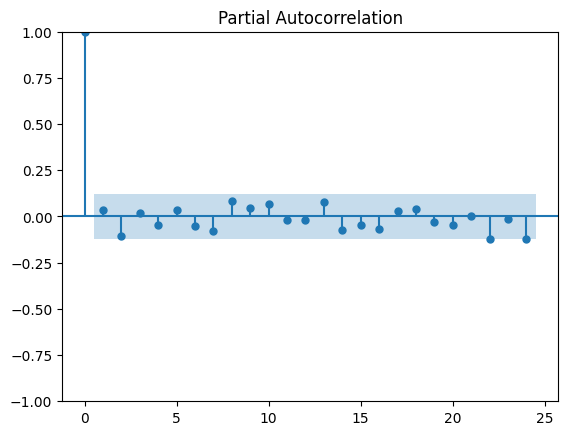

In [257]:
plot_pacf(X.Close.diff().dropna());

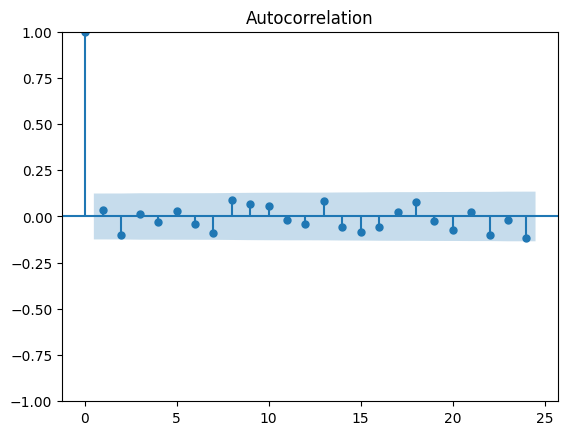

In [258]:
plot_acf(X.Close.diff().dropna());

In [231]:
df["Close_shifted"] = df["Close"].shift()

In [232]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,Close_shifted
Date,,,,,,,
2022-08-09,117.989998,118.199997,116.559998,117.500000,117.500000,15424300,NaN
2022-08-10,119.589996,121.779999,119.360001,120.650002,120.650002,20497000,117.500000
2022-08-11,122.080002,122.339996,119.550003,119.820000,119.820000,16671600,120.650002
2022-08-12,121.160004,122.650002,120.400002,122.650002,122.650002,16121100,119.820000
2022-08-15,122.209999,123.260002,121.570000,122.879997,122.879997,15525000,122.650002


In [233]:
columns_to_remove = df.columns.drop(['Close','Close_shifted'])

In [234]:
df.drop(columns_to_remove, axis = 1, inplace=True)

In [235]:
df.dropna(inplace=True)

In [236]:
df.head()

,Close,Close_shifted
Date,,
2022-08-10,120.650002,117.500000
2022-08-11,119.820000,120.650002
2022-08-12,122.650002,119.820000
2022-08-15,122.879997,122.650002
2022-08-16,122.510002,122.879997


In [237]:
y = df.Close.values
X = df.Close_shifted.values

In [238]:
train_size = int(len(X) * 0.80)

In [239]:
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(X)]

In [240]:
X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)

In [241]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [242]:
lr.coef_

array([0.97480486])

In [243]:
lr.intercept_

2.5871238391784317

In [244]:
y_pred = lr.predict(X_test)

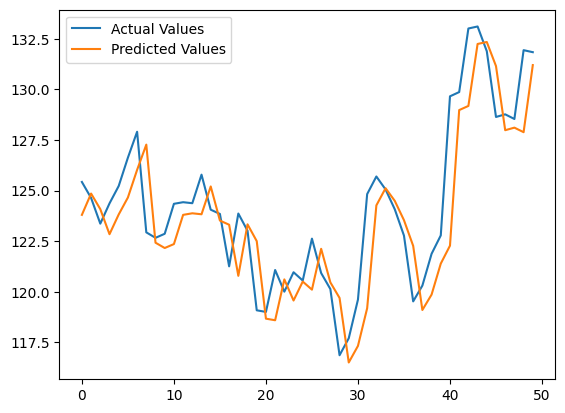

In [245]:
plt.plot(y_test, label="Actual Values")
plt.plot(y_pred, label="Predicted Values")
plt.legend()
plt.show()

In [264]:
model = ARIMA(y_train, order=(1,1,2))

In [265]:
model_fit = model.fit()

In [266]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -451.844
Date:                Sun, 27 Aug 2023   AIC                            911.689
Time:                        10:01:11   BIC                            924.862
Sample:                             0   HQIC                           917.020
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4444      0.301     -1.474      0.140      -1.035       0.146
ma.L1          0.4964      0.311      1.598      0.110      -0.113       1.105
ma.L2         -0.1230      0.095     -1.294      0.1

In [279]:
arima_y_pred = model_fit.forecast(steps=len(y_test))

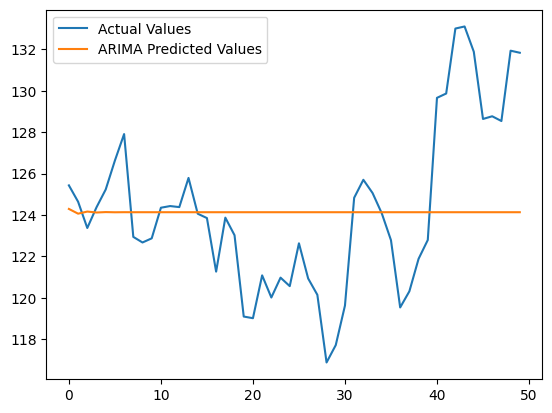

In [280]:
plt.plot(y_test, label="Actual Values")
plt.plot(arima_y_pred, label="ARIMA Predicted Values")
plt.legend()
plt.show()

In [275]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [276]:
# report performance
mse = mean_squared_error(y_test, arima_y_pred)
print('MSE: '+str(mse))

mae = mean_absolute_error(y_test, arima_y_pred)
print('MAE: '+str(mae))

rmse = math.sqrt(mean_squared_error(y_test, arima_y_pred))
print('RMSE: '+str(rmse))

mape = np.mean(np.abs(arima_y_pred - y_test)/np.abs(y_test))
print('MAPE: '+str(mape))

MSE: 15.96584803707989
MAE: 3.092057823292232
RMSE: 3.995728724160324
MAPE: 0.024711890161486717


#Other Approach

In [278]:
!pip install pmdarima

from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.4 MB/s eta 0:00:00


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=913.543, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=915.386, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=915.329, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=911.555, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.38 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.623 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -454.777
Date:                Sun, 27 Aug 2023   AIC                            911.555
Time:                        10:18:00   BIC                            914.848
Sample:                             0   HQIC                           912.888
                                - 200                                         
Covari

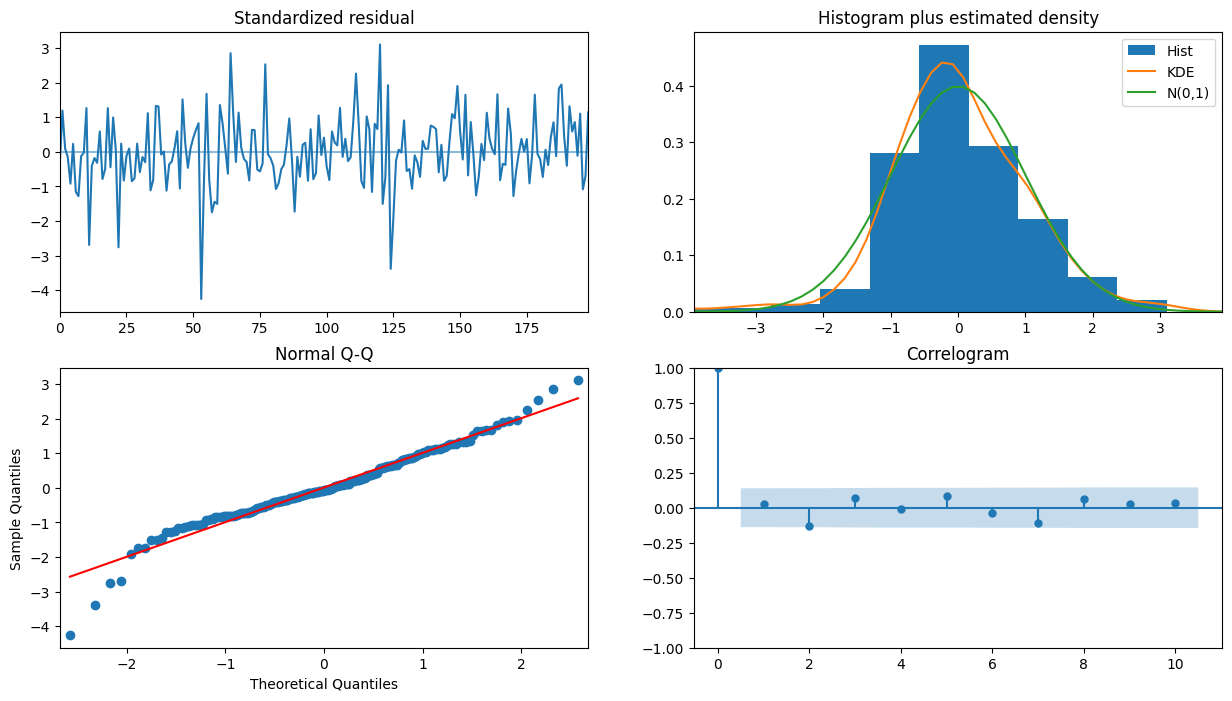

In [284]:
model_autoARIMA = auto_arima(y_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=20, max_q=20, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)


print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()


In [299]:
#Modeling
# Build Model
model = ARIMA(y_train, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  200
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -451.844
Date:                Sun, 27 Aug 2023   AIC                            911.689
Time:                        10:22:25   BIC                            924.862
Sample:                             0   HQIC                           917.020
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4444      0.301     -1.474      0.140      -1.035       0.146
ma.L1          0.4964      0.311      1.598      0.110      -0.113       1.105
ma.L2         -0.1230      0.095     -1.294      0.1

In [308]:
index = df.Close[train_size:len(X)].index
y_train = df.Close[0:train_size]
y_test = df.Close[train_size:len(X)]

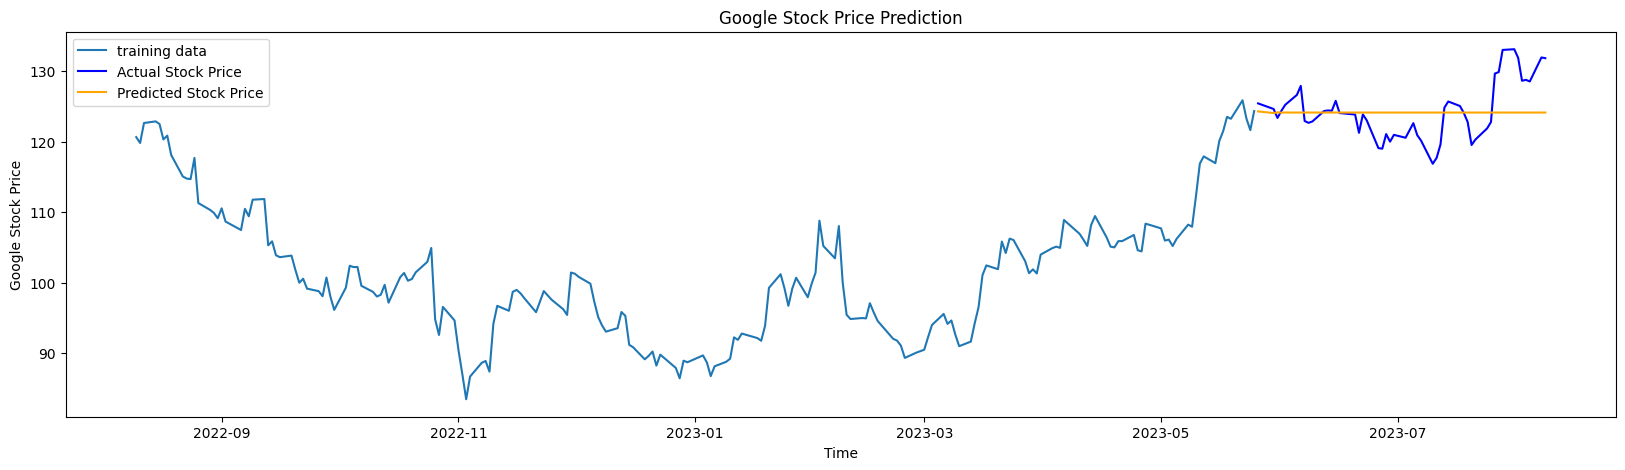

In [312]:
# Forecast
fc = fitted.forecast(steps=len(y_test))  # 95% conf
# Make as pandas series
fc_series = pd.Series(fc, index=index)
# Plot
plt.figure(figsize=(20,5), dpi=100)

plt.plot(y_train, label='training data')

plt.plot(y_test, color = 'blue', label='Actual Stock Price')

plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()


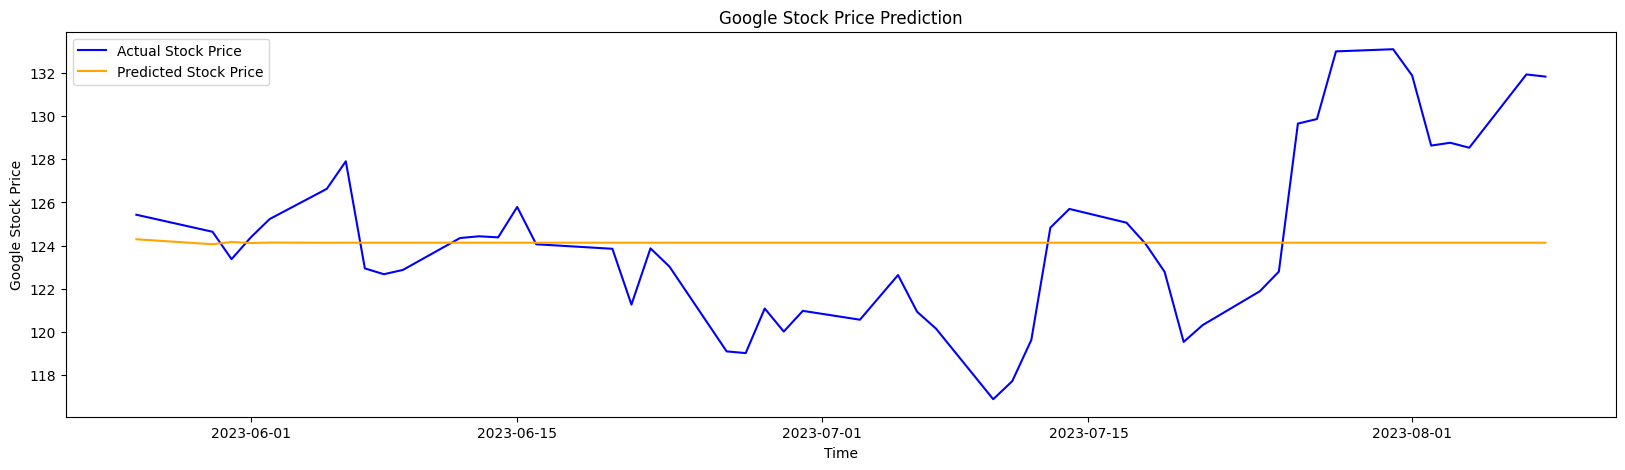

In [313]:
# Plot
plt.figure(figsize=(20,5), dpi=100)

plt.plot(y_test, color = 'blue', label='Actual Stock Price')

plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')

plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()